In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import matplotlib.pyplot as plt
import glob
import random
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cpu


In [3]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

## **Explore the data**

In [4]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1,Tyler_Hamilton,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2,Bernard_Siegel,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4,Blythe_Danner,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
5,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
6,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
7,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
8,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
9,Gene_Robinson,/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...


<AxesSubplot:xlabel='person'>

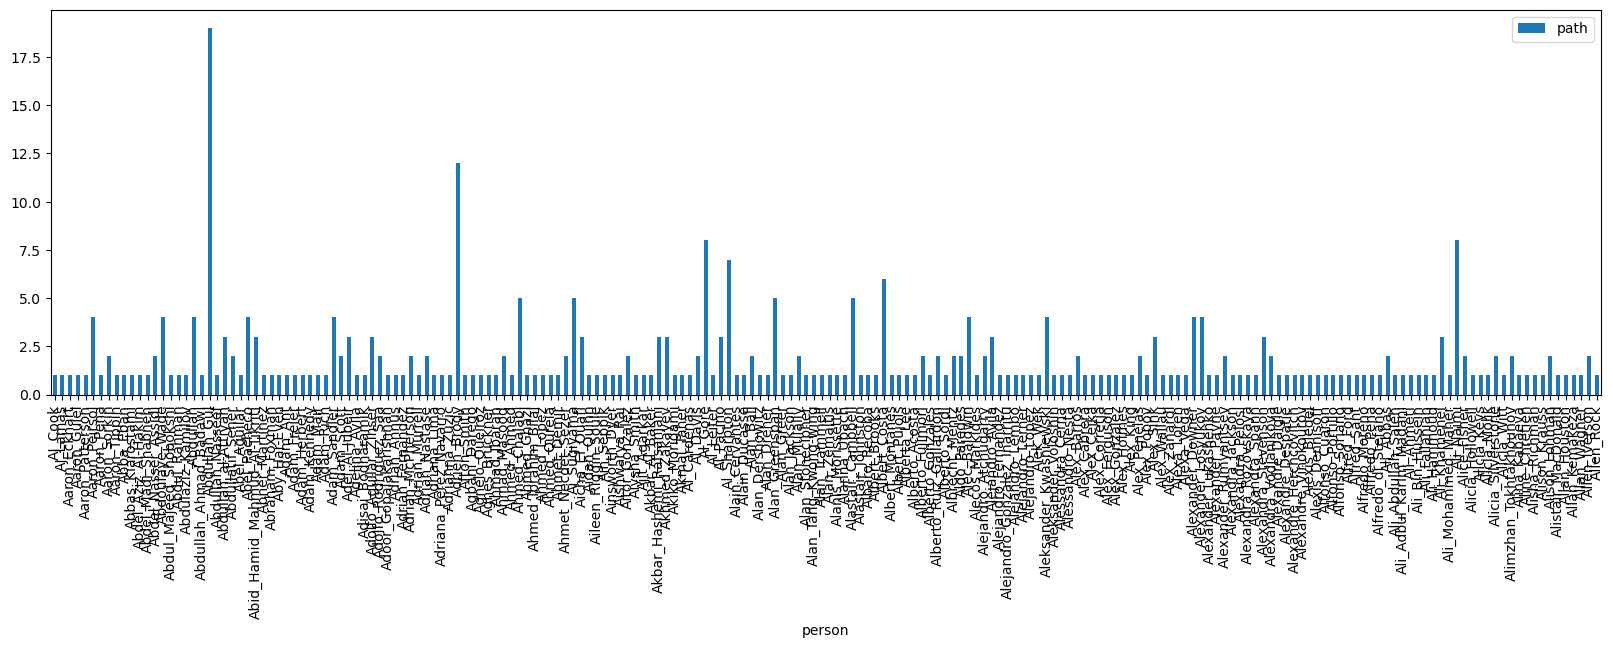

In [5]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

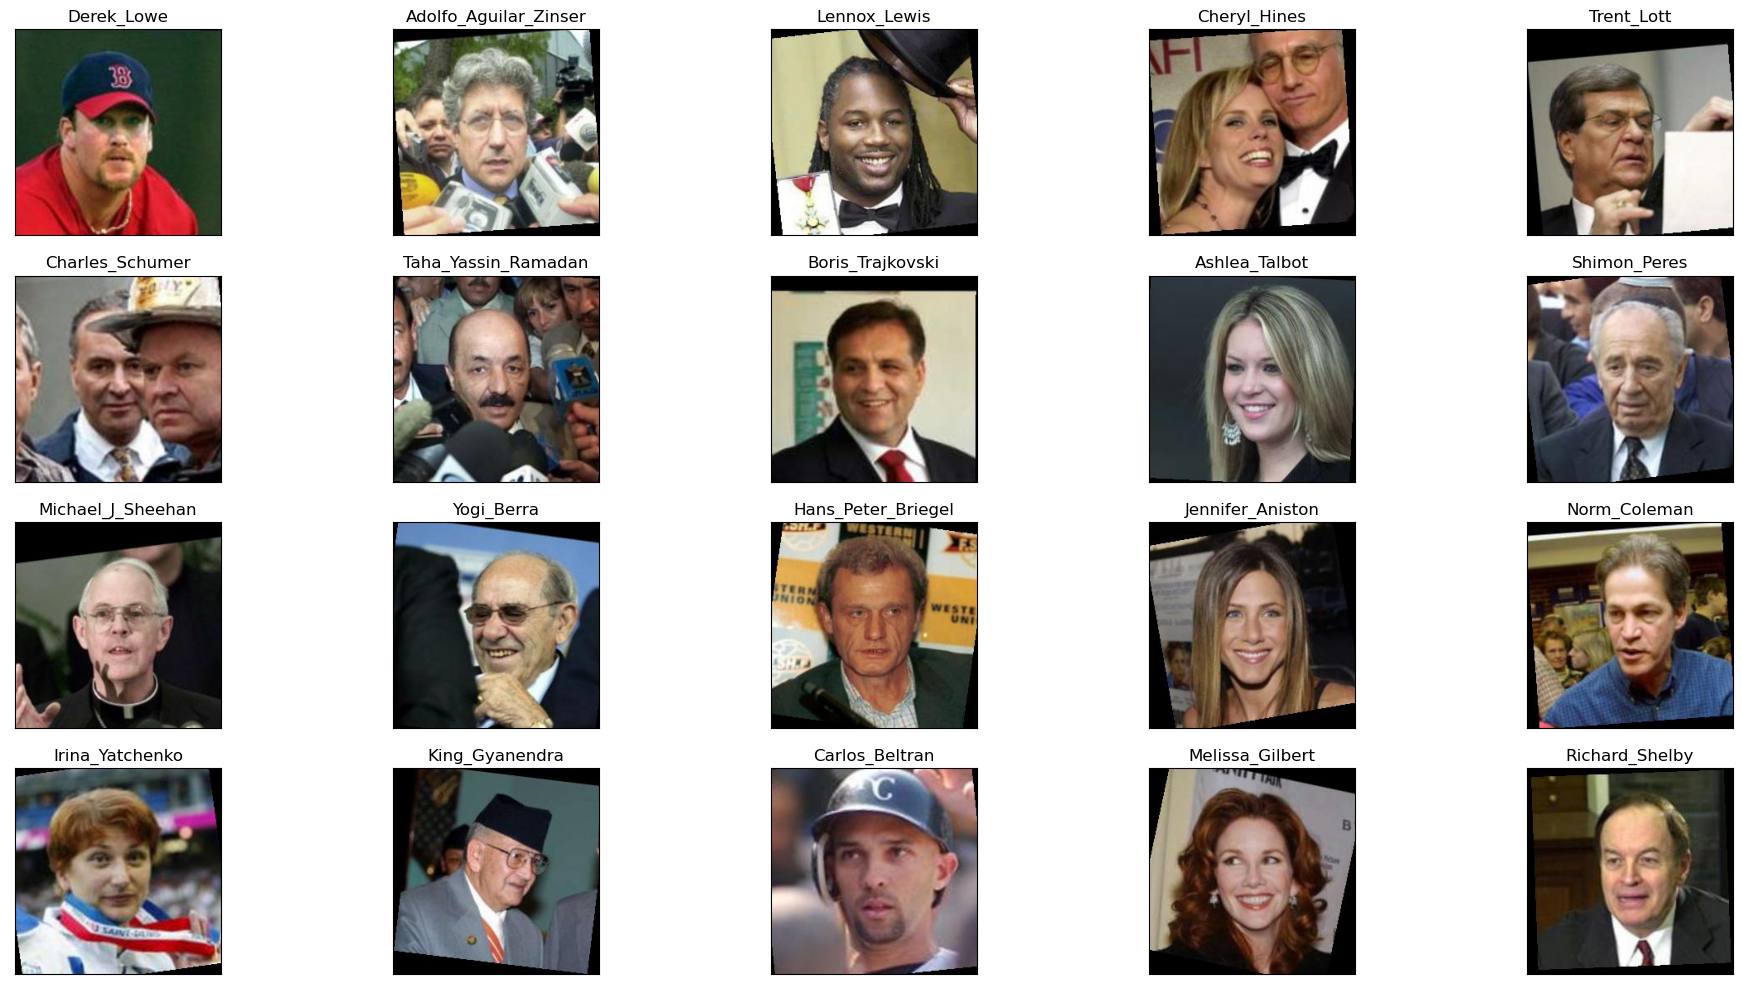

In [6]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## **Create dataloader and dataset classes**

In [7]:
# def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
#     df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
#     df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
#     photo_ids = []
#     for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
#         for fname in filenames:
#             if fname.endswith(".jpg"):
#                 fpath = os.path.join(dirpath,fname)
#                 photo_id = fname[:-4].replace('_',' ').split()
#                 person_id = ' '.join(photo_id[:-1])
#                 photo_number = int(photo_id[-1])
#                 photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

#     photo_ids = pd.DataFrame(photo_ids)
#     df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

#     assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
#     all_photos = df['photo_path'].apply(imageio.imread)\
#                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
#                                 .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

#     all_photos = np.stack(all_photos.values).astype('uint8')
#     all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
#     return all_photos,all_attrs

In [8]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, dataset_path, attributes_path, dx=80, dy=80, dimx=45, dimy=45, train_size=0.7, test_size=0.2, val_size=0.1, random_state=None):
        self.dataset_path = dataset_path
        self.attributes_path = attributes_path
        self.dx = dx
        self.dy = dy
        self.dimx = dimx
        self.dimy = dimy
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        
        self.df_attrs = pd.read_csv(self.attributes_path, sep='\t', skiprows=1)
        self.df_attrs = pd.DataFrame(self.df_attrs.iloc[:,:-1].values, columns=self.df_attrs.columns[1:])
        
        photo_ids = []
        for dirpath, dirnames, filenames in os.walk(self.dataset_path):
            for fname in filenames:
                if fname.endswith(".jpg"):
                    fpath = os.path.join(dirpath,fname)
                    photo_id = fname[:-4].replace('_',' ').split()
                    person_id = ' '.join(photo_id[:-1])
                    photo_number = int(photo_id[-1])
                    photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})
        
        photo_ids = pd.DataFrame(photo_ids)
        self.df = pd.merge(self.df_attrs,photo_ids,on=('person','imagenum'))
        assert len(self.df)==len(self.df_attrs),"lost some data when merging dataframes"
        
        all_photos = self.df['photo_path'].apply(Image.open)\
                                .apply(lambda img:img.crop((self.dx, self.dy, img.size[0]-self.dx, img.size[1]-self.dy)))\
                                .apply(lambda img: img.resize((self.dimx, self.dimy)))
        all_photos = np.stack([np.array(img) for img in all_photos.values]).astype('uint8')
        all_attrs = self.df.drop(["photo_path","person","imagenum"], axis=1)
        
        if random_state is not None:
            np.random.seed(random_state)
        
        perm = np.random.permutation(len(all_photos))
        train_end = int(self.train_size * len(all_photos))
        val_end = train_end + int(self.val_size * len(all_photos))
        
        self.train_data = all_photos[perm[:train_end]]
        self.train_labels = all_attrs.values[perm[:train_end]]
        self.val_data = all_photos[perm[train_end:val_end]]
        self.val_labels = all_attrs.values[perm[train_end:val_end]]
        self.test_data = all_photos[perm[val_end:]]
        self.test_labels = all_attrs.values[perm[val_end:]]
        
    def __len__(self):
        return len(self.train_data)
    
    def __getitem__(self, idx):
        image = self.train_data[idx].astype('float32')
        label = self.train_labels[idx].astype('float32')
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        label = torch.tensor(label, dtype=torch.float32)
        return image, label
    
    def get_test_data(self):
        return self.test_data, self.test_labels
    
    def get_train_data(self):
        return self.train_data, self.train_labels
    
    def get_val_data(self):
        return self.val_data

In [9]:
class ImageDataLoader():
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=4,
            pin_memory=True,
        )
        
    def __len__(self):
        return len(self.loader)
    
    def __iter__(self):
        for batch in self.loader:
            yield batch
    
    def get_test_batch(self):
        
            
    def show_grid(self, nrow=8, padding=2):
        images, labels = next(iter(self.loader))
        grid = make_grid(images, nrow=nrow, padding=padding, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()
        
    def get_image_size(self):
        image, _ = next(iter(self.loader))
        return tuple(image.size()[2:])

In [10]:
imageDataset = ImageDataset(
    dataset_path=DATASET_PATH,
    attributes_path=ATTRIBUTES_PATH,
    dx=80,
    dy=80,
    dimx=45,
    dimy=45,
    train_size=0.7,
    val_size=0.2,
    test_size=0.1,
    random_state=42,
)

dataloader = ImageDataLoader(imageDataset,
                            batch_size=32)

288


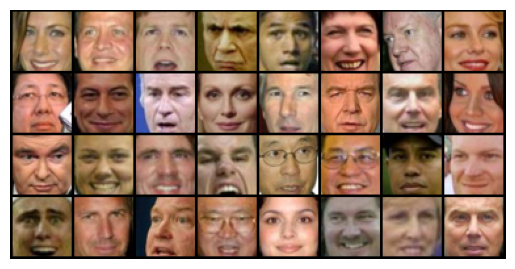

(45, 45)
Batch 1 size: 32
Batch 2 size: 32
Batch 3 size: 32
Batch 4 size: 32
Batch 5 size: 32
Batch 6 size: 32
Batch 7 size: 32
Batch 8 size: 32
Batch 9 size: 32
Batch 10 size: 32


In [15]:
# Get number of batches
print(len(dataloader))

# Show grid of images
dataloader.show_grid()

# Get size of images
print(dataloader.get_image_size())

# Iterate over batches and print batch size
for i, batch in enumerate(dataloader):
    images, labels = batch
    print(f"Batch {i+1} size:", len(images))
    if i % 10 == 9:
        break

In [16]:
print(next(iter(dataloader))[0].size())

torch.Size([32, 3, 45, 45])


In [ ]:
# def get_batch(data, batch_size=64):
#     total_len = data.shape[0]
#     for i in range(0, total_len, batch_size):
#         yield data[i:min(i+batch_size,total_len)]

# def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
#     plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         try:
#             plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
#             if with_title:
#                 plt.title(titles[i])
#             plt.xticks(())
#             plt.yticks(())
#         except:
#             pass

In [ ]:
# data, attrs = fetch_dataset()

In [ ]:
# #45,45
# IMAGE_H = data.shape[1]
# IMAGE_W = data.shape[2]

# N_CHANNELS = 3

In [ ]:
# data = np.array(data / 255, dtype='float32')
# X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# X_train = torch.FloatTensor(X_train)
# X_val = torch.FloatTensor(X_val)

## **Create VAE class**

In [ ]:
dim_z = 256

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
model_vae = VAE().to(DEVICE)

In [ ]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
#     with torch.set_grad_enabled(False):
#         pic = x_val[3]         
#         pic_input = pic.view(-1, 45*45*3)            
#         pic_input = pic_input.to(DEVICE)        
#         decoded,mu,logvar = model(inputs)        
#         pic_output = decoded[0].view(-1, 45*45*3).squeeze()
#         pic_output = pic_output.to("cpu") 
#         pic_input = pic_input.to("cpu")
#         plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001, min_lr=1e-5, factor=0.5, patience=5, device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, min_lr=min_lr, verbose=True)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            if epoch % (epochs // 10) == 0:
                print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))
            
            scheduler.step(val_loss)
    return history

In [ ]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=250, batch_size=512, lr=0.001)

In [ ]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();